In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from scipy.special import erf as sperf
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
root2over = 1/np.sqrt(2)
erf_max = sperf(root2over)

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
#     sigma = np.random.rand(1,size) + 0.5
#     for index in range(size):
#         def f0(sig):
#             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
#         res = spo.minimize(f0,sigma[0,index])
#         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = (x - np.mean(x,axis=0))/np.std(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def enet_solve(c,b):
    regr = ElasticNet(random_state=0,max_iter=10000)
    regr.fit(c,b)
    return regr.coef_

def moving_avg(a,window):
    cu = np.cumsum(a,axis=0,dtype=float)
    cu[window:] = cu[window:] - cu[:-window]
    return cu[window-1:]/window

def odd_power(h,power=3):
    sign = np.sign(h)
    return sign*np.power(np.abs(h),1/power)

def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0

#         delta = (npr.rand(1,size)+1)

        w = npr.rand(size,size) - 0.5
    #     w = w.dot(w.T)
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
    x[0] = npr.rand(1,size)-0.5
    for i in range(time_steps-1):
        if power<3:
            x[i+1] = (1)*x[i] + delta * np.tanh(x[i].dot(w)) + sigma*npr.normal(size=(1,size))
        else:
            x[i+1] = (1)*x[i] + delta * odd_power(x[i].dot(w),power) + sigma*npr.normal(size=(1,size))

#         x[i+1] = np.maximum(x_min,(1-rho)*x[i] + rho*np.sqrt(np.maximum(x_min,x[i].dot(w)))) \
#                             + np.exp(sigma*npr.normal(size=(1,size)))
    return x-np.mean(x,axis=0)[np.newaxis,:],w,sigma

    
def infer(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1):
    time_steps,size = x.shape
    x0 = (x[:] - np.mean(x[:],axis=0))
#     x0_max = 2*np.max(np.abs(x0),axis=0)
#     x0 /= x0_max[None,:]
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0) 
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y-y_mean[None,:]),axis=0)
#     y /= y_max[None,:]#now y is definitely within +/- 1
#     x0 = x0[:-1]/y_max[None,:]
    x0 = x0[:-1]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    if power<3:
        h = np.tanh(x0.dot(w))
    else:
        h = odd_power(x0.dot(w),power)
    for index in range(size):
        err_old,error = 0,np.inf
        #         print(index)
        while np.abs(error-err_old) > tol:
            zeros = np.abs(x0.dot(w[:,index])) < 1e-12
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))
            ratio[~zeros] = (x0[~zeros,:].dot(w[:,index]))/sperf(h[~zeros,index]*root2over)
            #             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            
            #             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*((s[:,index]/np.erf(h[:,index]*root2over))*x0.dot(w)[:,index])[:,np.newaxis],axis=0))
            err_old = error
            if power<3:
                h[:,index] = np.tanh(x0.dot(w[:,index]))
            else:
                h[:,index] = odd_power(x0.dot(w[:,index]),power)
            error = npl.norm(s[:,index]-sperf(h[:,index]*root2over))
    sigma = find_sigma(y,h)*np.sqrt(window)#*y_max[None,:]
    return w*sigma[0][None,:],sigma





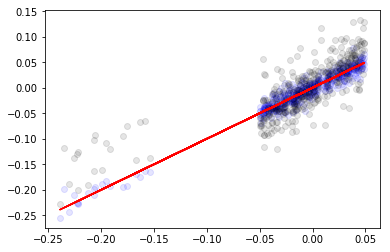

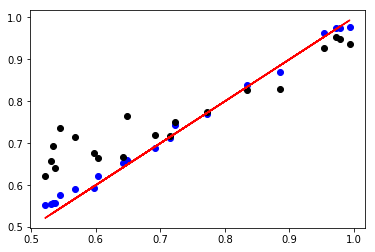

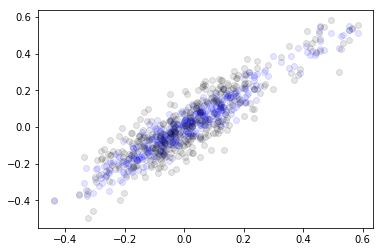

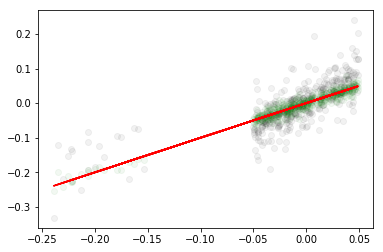

In [7]:
np.random.seed(31)
pp=1
x_true,w_true,sig_true = simulate(20,5000,coupling=0.1,power=pp)
w,sig = infer(x_true,window=1,power=pp)#,func=enet_solve)

w3,sig3 = infer(x_true,window=3,power=pp)#,func=enet_solve)

plt.plot(w_true,w,'bo',alpha=0.1)

plt.plot(w_true,w3,'ko',alpha=0.1)


plt.plot(w_true,w_true,'r-')

plt.show()
plt.close()
plt.plot(sig_true,sig,'bo')

plt.plot(sig_true,sig3,'ko')

plt.plot(sig_true[0],sig_true[0],'r-')

plt.show()
plt.close()

time_steps,size = x_true.shape
x_sim,w_sim,sig_sim = simulate(size,time_steps,w=w,sigma=sig,rho=0,power=pp)
plt.plot(time_shift_cov(x_true,shift=5),time_shift_cov(x_sim,shift=5),'bo',alpha=0.1)
x_sim,w_sim,sig_sim = simulate(size,time_steps,w=w3,sigma=sig3,rho=0,power=pp)
plt.plot(time_shift_cov(x_true,shift=5),time_shift_cov(x_sim,shift=5),'ko',alpha=0.1)

plt.show()
plt.close()
w_sim,sig_sim = infer(x_sim,power=pp)
plt.plot(w_true,w_sim,'ko',alpha=0.05)
plt.plot(w_true,w,'go',alpha=0.05)
plt.plot(w_true,w_true,'r-')
plt.show()
plt.close()




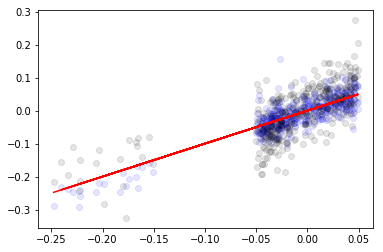

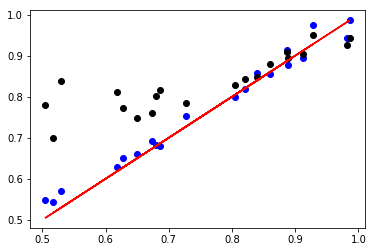

In [8]:
np.random.seed(13)
pp=1
x_true,w_true,sig_true = simulate(20,1000,coupling=0.1,power=pp)
w,sig = infer(x_true,window=1,power=pp)#,func=enet_solve)

w3,sig3 = infer(x_true,window=3,power=pp)#,func=enet_solve)

plt.plot(w_true,w,'bo',alpha=0.1)

plt.plot(w_true,w3,'ko',alpha=0.1)


plt.plot(w_true,w_true,'r-')

plt.show()
plt.close()
plt.plot(sig_true,sig,'bo')

plt.plot(sig_true,sig3,'ko')

plt.plot(sig_true[0],sig_true[0],'r-')

plt.show()
plt.close()



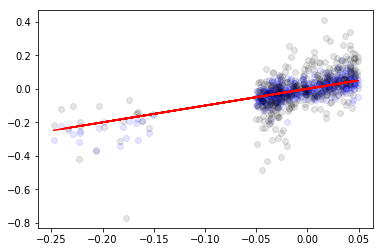

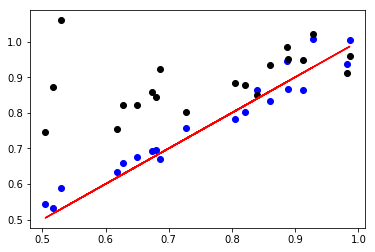

In [9]:
np.random.seed(13)
pp=1
x_true,w_true,sig_true = simulate(20,500,coupling=0.1,power=pp)
w,sig = infer(x_true,window=1,power=pp)#,func=enet_solve)

w3,sig3 = infer(x_true,window=3,power=pp)#,func=enet_solve)

plt.plot(w_true,w,'bo',alpha=0.1)

plt.plot(w_true,w3,'ko',alpha=0.1)


plt.plot(w_true,w_true,'r-')

plt.show()
plt.close()
plt.plot(sig_true,sig,'bo')

plt.plot(sig_true,sig3,'ko')

plt.plot(sig_true[0],sig_true[0],'r-')

plt.show()
plt.close()



In [136]:
def simulate2(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0

        delta = (npr.rand(1,size)+1)*4

        w = npr.rand(size,size) - 0.5
    #     w = w.dot(w.T)
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
    x[0] = npr.rand(1,size)-0.5
    for i in range(time_steps-1):
        if power<3:
            x[i+1] = (1)*x[i] + delta * np.tanh(x[i].dot(w)) + sigma*npr.normal(size=(1,size))
        else:
            x[i+1] = (1)*x[i] + delta * odd_power(x[i].dot(w),power) + sigma*npr.normal(size=(1,size))

#         x[i+1] = np.maximum(x_min,(1-rho)*x[i] + rho*np.sqrt(np.maximum(x_min,x[i].dot(w)))) \
#                             + np.exp(sigma*npr.normal(size=(1,size)))
    y = np.diff(x,axis=0) 
#     y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
#     y /= y_max[None,:]#now y is definitely within +/- 1
#     x /= y_max[None,:]
    return x,y_max[:,None]*w,sigma/y_max[None,:]

def infer2(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1):
    time_steps,size = x.shape
    x0 = np.copy(x)-np.mean(x,axis=0)[None,:]
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0) 
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
    y /= y_max[None,:]#now y is definitely within +/- 1
    x0 = x0[:-1]/y_max[None,:]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    if power<3:
        h = np.tanh(x0.dot(w))
    else:
        h = odd_power(x0.dot(w),power)
    for index in range(size):
        err_old,error = 0,np.inf
        #         print(index)
        while np.abs(error-err_old) > tol:
            zeros = np.abs(x0.dot(w[:,index])) < 1e-12
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))
            ratio[~zeros] = (x0[~zeros,:].dot(w[:,index]))/np.erf(h[~zeros,index]*root2over)
            #             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            w[:,index] = func(c+0.1*np.eye(size),np.mean((x0-np.mean(x0,axis=0)[None,:])*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            
            #             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*((s[:,index]/np.erf(h[:,index]*root2over))*x0.dot(w)[:,index])[:,np.newaxis],axis=0))
            err_old = error
            if power<3:
                h[:,index] = np.tanh(x0.dot(w[:,index]))
            else:
                h[:,index] = odd_power(x0.dot(w[:,index]),power)
            error = npl.norm(s[:,index]-np.erf(h[:,index]*root2over))
    sigma = find_sigma(y,h)#*np.sqrt(window)#*y_max[None,:]
    return w,sigma

#     return w/y_max.reshape(size)[:,None],sigma*y_max[None,:]






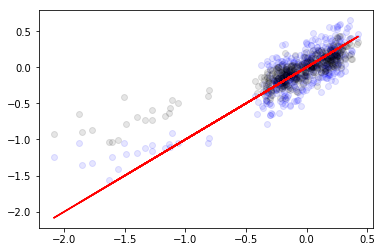

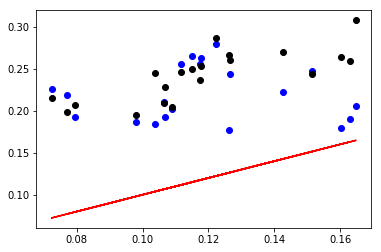

In [137]:
np.random.seed(13)
pp=1
x_true,w_true,sig_true = simulate2(20,20000,coupling=0.1,power=pp)
w,sig = infer2(x_true,window=1,power=pp)#,func=enet_solve)

w3,sig3 = infer2(x_true,window=7,power=pp)#,func=enet_solve)

plt.plot(w_true,w,'bo',alpha=0.1)

plt.plot(w_true,w3,'ko',alpha=0.1)


plt.plot(w_true,w_true,'r-')

plt.show()
plt.close()
plt.plot(sig_true,sig,'bo')

plt.plot(sig_true,sig3,'ko')

plt.plot(sig_true[0],sig_true[0],'r-')

plt.show()
plt.close()




In [132]:
#Now add in a bias
def simulate3(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1,bias=0):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0

        delta = (npr.rand(1,size)+1)*4

        bias = (npr.rand(1,size)-0.5)*2


        w = npr.rand(size,size) - 0.5
    #     w = w.dot(w.T)
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
    x[0] = npr.rand(1,size)-0.5
    for i in range(time_steps-1):
        if power<3:
            x[i+1] = (1)*x[i] + delta * np.tanh(bias + x[i].dot(w)) + sigma*npr.normal(size=(1,size))
        else:
            x[i+1] = (1)*x[i] + delta * odd_power(bias + x[i].dot(w),power) + sigma*npr.normal(size=(1,size))

#         x[i+1] = np.maximum(x_min,(1-rho)*x[i] + rho*np.sqrt(np.maximum(x_min,x[i].dot(w)))) \
#                             + np.exp(sigma*npr.normal(size=(1,size)))
    y = np.diff(x,axis=0) 
#     y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
#     y /= y_max[None,:]#now y is definitely within +/- 1
#     x /= y_max[None,:]
    return x,y_max[:,None]*w,sigma/y_max[None,:],bias

def bias_update(y,h,b_in,pp):
    y_plus = y>0
    if pp==1:
        def f0(bias):
            return np.mean(y[y_plus]-np.tanh(bias+h[y_plus]))**2 + np.mean(y[~y_plus]-np.tanh(bias+h[~y_plus]))**2
    else:
        def f0(bias):
            return np.mean(y[y_plus]-odd_power(bias[0,index] + h[y_plus],pp))**2 + \
                    np.mean(y[~y_plus]-odd_power(bias[0,index] + h[~y_plus],pp))**2

    res = spo.minimize(f0,b_in)
    return res.x
    

def infer3(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1):
    time_steps,size = x.shape
    x0 = np.copy(x)
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0) 
    y_mean = np.mean((y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
    y /= y_max[None,:]#now y is definitely within +/- 1
    print(np.max(y_mean))
    x0 = x0[:-1]/y_max[None,:]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    bias = npr.rand(1,size) - 0.5
    if power<3:
        h = np.tanh(bias + x0.dot(w))
    else:
        h = odd_power(bias + x0.dot(w),power)
    for index in range(size):
        err_old,error = 0,np.inf
        #         print(index)
        while np.abs(error-err_old) > tol:
            zeros = np.abs(bias[0,index] + x0.dot(w[:,index])) < 1e-12
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))
            ratio[~zeros] = (bias[0,index] + x0[~zeros,:].dot(w[:,index]))/np.erf(h[~zeros,index]*root2over)
            #             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            w[:,index] = func(c+0.1*np.eye(size),np.mean((x0-np.mean(x0,axis=0)[None,:])*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            
            #             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*((s[:,index]/np.erf(h[:,index]*root2over))*x0.dot(w)[:,index])[:,np.newaxis],axis=0))
            h_temp = x0.dot(w[:,index])
            bias[0,index] = bias_update(y[:,index],h_temp,bias[0,index],pp=power)
            err_old = error
            if power<3:
                h[:,index] = np.tanh(bias[0,index] + h_temp)
            else:
                h[:,index] = odd_power(bias[0,index] + h_temp,power)
            error = npl.norm(s[:,index]-np.erf(h[:,index]*root2over))
    sigma = find_sigma(y,h)*np.sqrt(window)#*y_max[None,:]
    return w,sigma,bias

#     return w/y_max.reshape(size)[:,None],sigma*y_max[None,:]







0.006943013812310148
0.005924153001810015


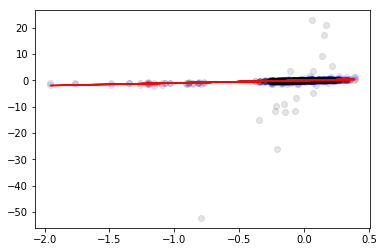

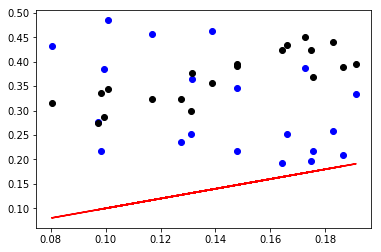

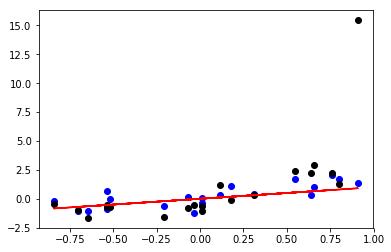

In [135]:
np.random.seed(23)
pp=1
x_true,w_true,sig_true,bias_true = simulate3(20,1000,coupling=0.1,power=pp)
w,sig,bias = infer3(x_true,window=1,power=pp)#,func=enet_solve)

w3,sig3,bias3 = infer3(x_true,window=2,power=pp)#,func=enet_solve)

plt.plot(w_true,w,'bo',alpha=0.1)

plt.plot(w_true,w3,'ko',alpha=0.1)


plt.plot(w_true,w_true,'r-')

plt.show()
plt.close()
plt.plot(sig_true,sig,'bo')

plt.plot(sig_true,sig3,'ko')

plt.plot(sig_true[0],sig_true[0],'r-')

plt.show()
plt.close()

plt.plot(bias_true,bias,'bo')

plt.plot(bias_true,bias3,'ko')

plt.plot(bias_true[0],bias_true[0],'r-')

plt.show()
plt.close()





In [10]:
def simulate4(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1,bias=0):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0        
        if power<3: delta = (npr.rand(1,size)+1)*4
        else: delta = odd_power(npr.rand(1,size)+1,power)        
        bias = (npr.rand(1,size)-0.5)*2
        w = npr.rand(size,size) - 0.5
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
    x[0] = npr.rand(1,size)-0.5
    for i in range(time_steps-1):
        if power<3:
            x[i+1] = (1)*x[i] + delta * np.tanh(bias + x[i].dot(w)) + sigma*npr.normal(size=(1,size))
        else:
            x[i+1] = (1)*x[i] + delta * odd_power(bias + x[i].dot(w),power) + sigma*npr.normal(size=(1,size))
    y = np.diff(x,axis=0)
    y_max = np.max(np.abs(y),axis=0)
    if power<3:
        return x,y_max[:,None]*w,sigma/y_max[None,:],bias
    else:
        opd = odd_power(delta,1/power)
        return x,opd[0][None,:]*w,sigma,opd*bias

def bias_update(y,h,b_in,pp):
    y_plus = y>0
    if pp==1:
        def f0(bias):
            return np.mean(y[y_plus]-np.tanh(bias+h[y_plus]))**2 + np.mean(y[~y_plus]-np.tanh(bias+h[~y_plus]))**2
    else:
        def f0(bias):
            return np.mean(y[y_plus]-odd_power(bias + h[y_plus],pp))**2 + \
                np.mean(y[~y_plus]-odd_power(bias + h[~y_plus],pp))**2
    res = spo.minimize(f0,b_in)
    return res.x


def infer4(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1,verbose=False):
    time_steps,size = x.shape
    x0 = np.copy(x)
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0)
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
    if power<3:
        y /= y_max[None,:]#now y is definitely within +/- 1
        x0 = x0/y_max[None,:]
    x0 = x0[:-1]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    bias = npr.rand(1,size) - 0.5
    if power<3:
        h = np.tanh(bias + x0.dot(w))
    else:
        h = odd_power(bias + x0.dot(w),power)
    for index in range(size):
        err_old,error,counter = 0,np.inf,0
        #         print(index)
        while np.abs(error-err_old) > tol and counter < max_iter:
            counter += 1
            zeros = np.abs(bias[0,index] + x0.dot(w[:,index])) < 1e-7
            if power<3:
                ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))
            else:
                ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))*h[:,index]**(power-1)
            ratio[~zeros] = (bias[0,index] + x0[~zeros,:].dot(w[:,index]))/np.erf(h[~zeros,index]*root2over)
            w[:,index] = func(c+0.1*np.eye(size),np.mean((x0-np.mean(x0,axis=0)[None,:])*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            h_temp = x0.dot(w[:,index])
            bias[0,index] = bias_update(y[:,index],h_temp,bias[0,index],pp=power)
            err_old = error
            if power<3:
                h[:,index] = np.tanh(bias[0,index] + h_temp)
                error = npl.norm(s[:,index]-np.erf(h[:,index]*root2over)/erf_max)
            else:
                h[:,index] = odd_power(bias[0,index] + h_temp,power)
                error = npl.norm(s[:,index]-np.erf(h[:,index]*root2over))
#             print(counter,error)
    sigma = find_sigma(y,h)*np.sqrt(window)#*y_max[None,:]
    return w,sigma,bias


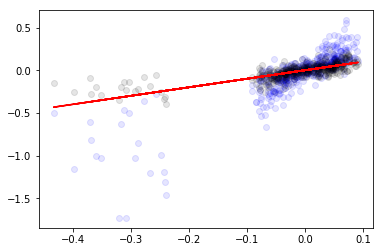

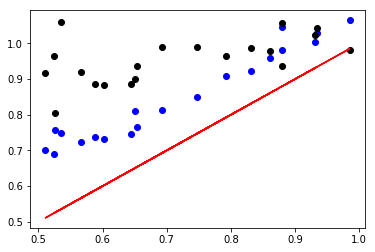

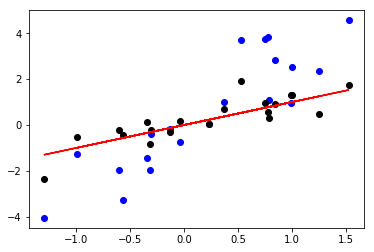

In [10]:
np.random.seed(21)
pp=7
x_true,w_true,sig_true,bias_true = simulate4(20,1000,coupling=0.1,power=pp)
w,sig,bias = infer4(x_true,window=1,power=pp-4)#,func=enet_solve)

w3,sig3,bias3 = infer4(x_true,window=3,power=pp-4)#,func=enet_solve)

plt.plot(w_true,w,'bo',alpha=0.1)

plt.plot(w_true,w3,'ko',alpha=0.1)


plt.plot(w_true,w_true,'r-')

plt.show()
plt.close()
plt.plot(sig_true,sig,'bo')

plt.plot(sig_true,sig3,'ko')

plt.plot(sig_true[0],sig_true[0],'r-')

plt.show()
plt.close()

plt.plot(bias_true,bias,'bo')

plt.plot(bias_true,bias3,'ko')

plt.plot(bias_true[0],bias_true[0],'r-')

plt.show()
plt.close()

